In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from new import *

# RG flow

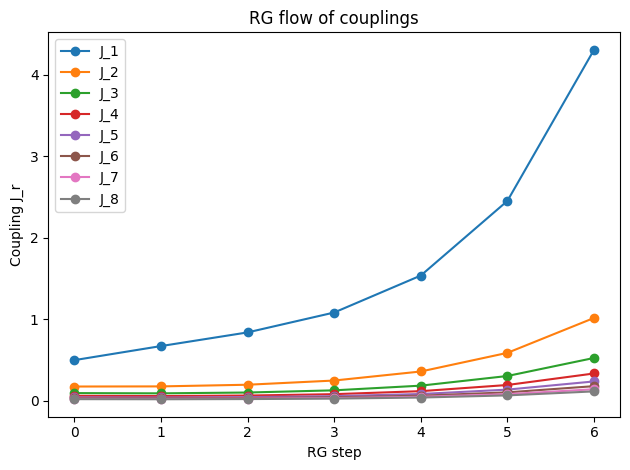

In [9]:
J0 = 0.5
a = 1.5
max_dist_final = 8
n_steps = 6

J_list, T_list = generate_rg_flow(J0, a, max_dist_final, n_steps, trace_TM=True, TM_r=1)
flows = extract_flows(J_list, max_dist_final)
plot_rg_flow(flows, distances_to_plot=[1, 2, 3, 4, 5, 6, 7, 8])

# Phase determination

In [5]:
J0 = 1
a = 1.5

phase, step = find_phase(
        J0, a,
        TM_r=1,
        max_dist_final=8,
        n_steps=5,
        threshold=0.1
    )
print(f"Phase at J0={J0}, a={a}: {phase} (decided at step {step})")

Phase at J0=1, a=1.5: ferromagnetic (decided at step 1)


# Critical point

In [3]:
a = 1.5
J_low  = 0.1    # disorder
J_high = 10.0    # ferromagnetic

Jc = find_critical_J(a, J_low, J_high)
print("Critical J:", Jc)
print("Critical Temperature (1/J):", 1.0/Jc)

Critical J: 0.409375
Critical Temperature (1/J): 2.4427480916030535


## Critical line

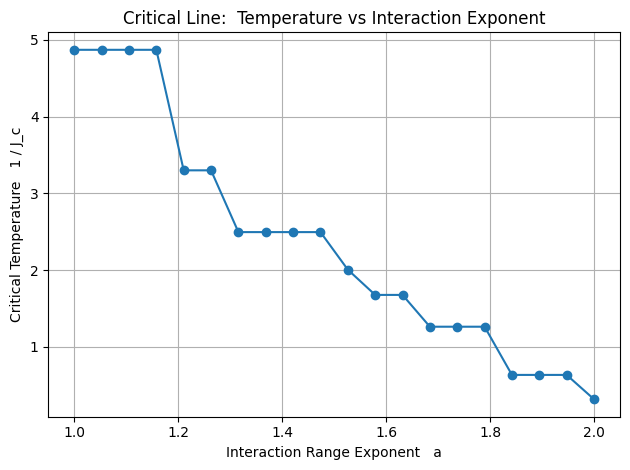

In [5]:
# Scan a from 1 to 2 using 15 points
a_vals, Jc_vals = compute_and_plot_critical_line(
    a_min=1.0,
    a_max=2.0,
    n_points=20,
    J_low_init=1/100,
    J_high_init=100.0,
    TM_r=2,
    max_dist_final=5,
    n_steps=6,
    threshold=0.1,)

Finding Jc for a = 1.0000 ...
Finding Jc for a = 1.1100 ...
Finding Jc for a = 1.2200 ...
Finding Jc for a = 1.3300 ...
Finding Jc for a = 1.4400 ...
Finding Jc for a = 1.5500 ...
Finding Jc for a = 1.6600 ...
Finding Jc for a = 1.7700 ...
Finding Jc for a = 1.8800 ...
Finding Jc for a = 1.9900 ...


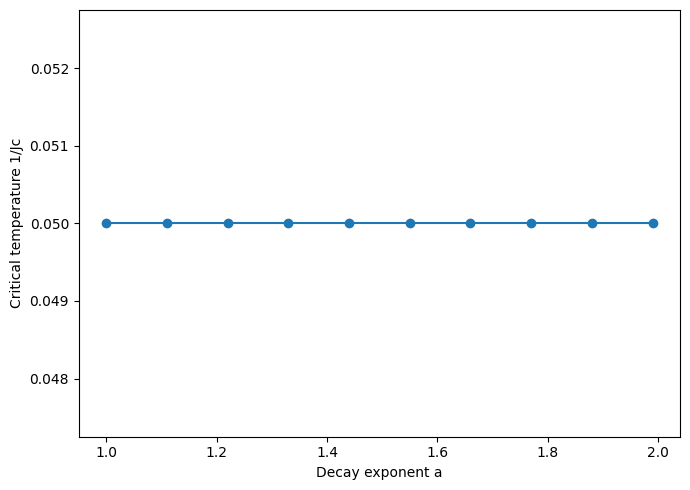

In [3]:
a_min=1
a_max=1.99

Jlow=0.1
Jhigh=20.0
tol=1e-6

a_vals = np.linspace(a_min, a_max, 10)
Jc_vals = np.zeros_like(a_vals)

for i, a in enumerate(a_vals):
    print(f"Finding Jc for a = {a:.4f} ...")
    Jc_vals[i] = find_Jc(a, tol=tol, Jlow=Jlow, Jhigh=Jhigh, max_steps=6)
    print(f"Findi Jc for a = {a:.4f} ...")

# Plot a vs 1/Jc
Tc_vals = 1.0 / Jc_vals

plt.figure(figsize=(7,5))
plt.plot(a_vals, Tc_vals, marker='o')
plt.xlabel("Decay exponent a")
plt.ylabel("Critical temperature 1/Jc")
plt.grid(False)
plt.tight_layout()
plt.show()

# Fixed point

In [5]:
Jc = find_critical_J(a=1.5, J_low=0.001,
    J_high=100.0,
    TM_r=1,
    max_dist_final=10,
    n_steps=6,
    threshold=0.1,
    tol=0.001,
    max_iter=20,)
Jc

0.39162109375

In [23]:
J0 = build_initial_guess(Jc, a=1.5, D=1000)
J0

array([0.00000000e+00, 3.91621094e-01, 1.38458966e-01, ...,
       1.24213919e-05, 1.24027458e-05, 1.23841464e-05], shape=(1001,))

In [24]:
J_star, info = newton_rg_lstsq(J0, verbose=True)
J_star

[lstsq] iter 0: D=1000, D1=332, ||J'-J||=7.368e-02
[lstsq] iter 1: D=1000, D1=332, ||J'-J||=3.261e-02
[lstsq] iter 2: D=1000, D1=332, ||J'-J||=1.383e-02
[lstsq] iter 3: D=1000, D1=332, ||J'-J||=5.837e-03
[lstsq] iter 4: D=1000, D1=332, ||J'-J||=2.434e-03
[lstsq] iter 5: D=1000, D1=332, ||J'-J||=8.905e-04
[lstsq] iter 6: D=1000, D1=332, ||J'-J||=1.220e-04
[lstsq] iter 7: D=1000, D1=332, ||J'-J||=2.065e-05
[lstsq] iter 8: D=1000, D1=332, ||J'-J||=4.569e-06
[lstsq] iter 9: D=1000, D1=332, ||J'-J||=1.080e-06


array([0.00000000e+00, 3.79884042e-01, 1.18978887e-01, ...,
       1.83168535e-05, 1.24027458e-05, 1.23841464e-05], shape=(1001,))

In [25]:
err = check_fixed_point(J_star)
err

Fixed-point error norm = 2.588e-07
✔ Fixed point verified.


np.float64(2.587687557897829e-07)

# Thermal exponent yT

In [12]:
N=10

T, J_head = recursion_matrix_at_fixed_point(J_star, N)
y_T, lambda_T, eigs = thermal_exponent_from_T(T, b=3.0)

print("Largest relevant eigenvalue λ_T:", lambda_T)
print("Thermal scaling exponent y_T:", y_T)
print("Correlation length exponent ν ≈ 1/y_T:", 1.0/y_T)

Largest relevant eigenvalue λ_T: 1.0557475484628578
Thermal scaling exponent y_T: 0.049379652228238195
Correlation length exponent ν ≈ 1/y_T: 20.25125643611036


## Stability of yT with N

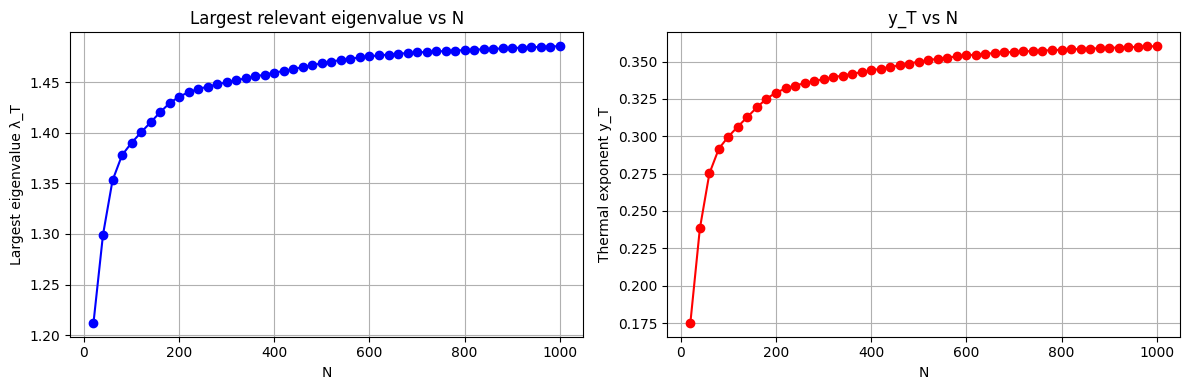

In [26]:
# ----- parameters -----
b = 3.0
N_min = 20
N_max = len(J_star) - 1    # maximum allowed head size

Ns = []
lambda_Ts = []
yTs = []

# ----- main sweep -----
for N in range(N_min, N_max + 1, 20):
    T, J_head = recursion_matrix_at_fixed_point(J_star, N)
    y_T, lambda_T, eigs = thermal_exponent_from_T(T, b)

    
    Ns.append(N)
    lambda_Ts.append(lambda_T.real)
    yTs.append(y_T.real)

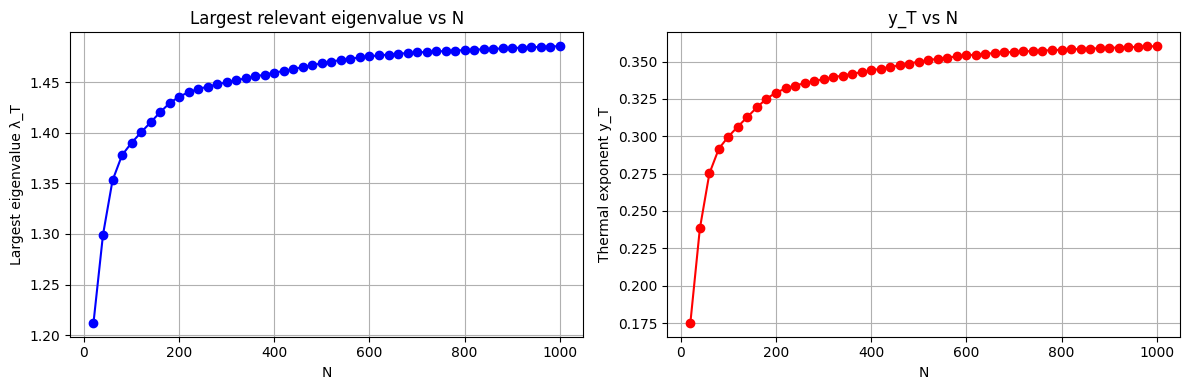

In [27]:
# ----- plots -----
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(Ns, lambda_Ts, 'b-o')
ax[0].set_xlabel("N")
ax[0].set_ylabel("Largest eigenvalue λ_T")
ax[0].set_title("Largest relevant eigenvalue vs N")
ax[0].grid()

ax[1].plot(Ns, yTs, 'r-o')
ax[1].set_xlabel("N")
ax[1].set_ylabel("Thermal exponent y_T")
ax[1].set_title("y_T vs N")
ax[1].grid()

plt.tight_layout()
plt.savefig("../figures/yT_stability.png")
plt.show()

# Magnetization

In [2]:
Jc = find_critical_J(a=1.5, J_low=1e-3, J_high=1e2, TM_r=1, max_dist_final=10,
                     n_steps=6, threshold=0.1, tol=0.001, max_iter=20)
J0 = build_initial_guess(Jc, a=1.5, D=200)
J_star, info = newton_rg_lstsq(J0, verbose=True)
err = check_fixed_point(J_star)

yH, alphaH = magnetic_exponent_yH(J_star, eps=1e-8, b=3.0)
print("dH'/dH at fixed point =", alphaH)
print("y_H =", yH)

[lstsq] iter 0: D=200, D1=66, ||J'-J||=7.368e-02
[lstsq] iter 1: D=200, D1=66, ||J'-J||=3.260e-02
[lstsq] iter 2: D=200, D1=66, ||J'-J||=1.376e-02
[lstsq] iter 3: D=200, D1=66, ||J'-J||=5.616e-03
[lstsq] iter 4: D=200, D1=66, ||J'-J||=1.389e-03
[lstsq] iter 5: D=200, D1=66, ||J'-J||=2.095e-04
[lstsq] iter 6: D=200, D1=66, ||J'-J||=4.020e-05
[lstsq] iter 7: D=200, D1=66, ||J'-J||=9.272e-06
[lstsq] iter 8: D=200, D1=66, ||J'-J||=2.126e-06
[lstsq] iter 9: D=200, D1=66, ||J'-J||=4.530e-07
Fixed-point error norm = 9.450e-08
✔ Fixed point verified.
dH'/dH at fixed point = 2.225355888452185
y_H = 0.7281156973617221


In [7]:
a = 1.2

M = magnetization(2, a, 1, max_dist_final=4, max_steps=10)
print("M =", M)

M = 0.9997653478550257


In [ ]:
# Parameters
a = 1.5
Jc = find_critical_J(a)
print(f"Jc = {Jc}")
T_values = np.linspace(0.1, 5.0, 10)
J_values = 1.0 / T_values

M_values = [magnetization(J0, a, Jc) for J0 in J_values]

plt.figure(figsize=(7,5))
plt.plot(T_values, M_values)
plt.xlabel("Temperature T = 1/J")
plt.ylabel("Magnetization M")
plt.grid(False)
plt.show()

Jc = 0.4005859375


# Critical exponents

In [ ]:
result = compute_exponents_over_a(
    a_min=1.0, a_max=2.0, num_points=10,
    D_init=100, N_matrix=10, d_dim=1.0, b=3.0)

plot_exponents(result)